In [1]:
# Importing useful modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from  xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from scipy.stats import pearsonr
from scipy.stats import norm

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Data Exploration

In [3]:
# Reading dataset
dataset = pd.read_excel("Dataset for Data Science Business Case.xlsx", sheet_name=1)
dataset.head()

,Store,Account ID,SquareFeet,Rented?,ReserveDate,Move In Date,Move Out Date,Promotion Name,Source,RentRate,StreetRate,Concession,Region,Previously Used Storage?,Purpose?,Storage Reason
0,3475,105000,0,False,2012-11-11 16:06:13.897,2012-11-17 06:24:08.897,NaT,NaN,Store Reservation,81.0,81.0,0.0,Inland Empire,NaN,NaN,NaN
1,4115,105001,25,False,2012-11-11 16:06:51.421,2012-11-11 00:00:27.421,NaT,NaN,Store Reservation,84.0,84.0,0.0,Ohio,NaN,NaN,NaN
2,4615,105002,200,False,2012-11-11 16:36:28.175,2012-11-11 01:07:02.175,NaT,NaN,Store Reservation,246.0,246.0,0.0,Other Southeast,NaN,NaN,NaN
3,1615,105003,300,True,2012-11-11 17:05:25.627,2012-11-11 17:05:27.627,NaT,NaN,Web Reservation,224.0,224.0,0.0,Inland Empire,No,Other,Other
4,3355,105004,50,False,2012-11-11 17:08:41.900,2012-11-13 03:37:55.900,NaT,NaN,Web Reservation,64.0,64.0,0.0,Inland Empire,NaN,NaN,NaN


In [4]:
dataset.shape

(58664, 16)

In [5]:
len(dataset['Account ID'].value_counts())

58664

Account ID are unique

In [6]:
len(dataset['Store'].value_counts())

345

Store ID are repeating

In [7]:
# Checking outliers in SquareFeet
dataset['SquareFeet'].describe()

count    58664.000000
mean        97.564997
std         79.105366
min          0.000000
25%         50.000000
50%         75.000000
75%        150.000000
max       1300.000000
Name: SquareFeet, dtype: float64

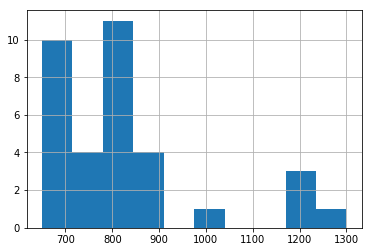

In [8]:
dataset['SquareFeet'][dataset['SquareFeet']>600].hist()

Enough values are present above 600 so looks genuine data, not removing any rows

In [9]:
dataset['Rented?'].value_counts()/dataset.shape[0]

True     0.625494
False    0.374506
Name: Rented?, dtype: float64

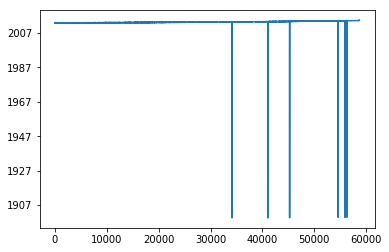

In [10]:
dataset['Move In Date'].plot()

Some Move In Date are way too old, looks data entry error

In [11]:
dataset['Move In Date'].dtype

dtype('<M8[ns]')

In [12]:
# Changing data type
dataset['Move In Date'] = pd.to_datetime(dataset['Move In Date'])
dataset['Move Out Date'] = pd.to_datetime(dataset['Move Out Date'])

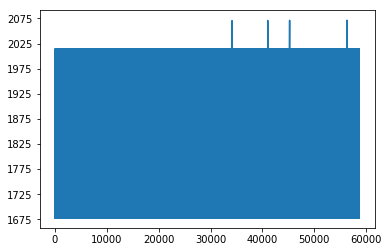

In [13]:
dataset['Move Out Date'].plot()

Some Move Out Date are way in future, again looks data entry error

In [14]:
dataset['Move Out Date'].describe()

count                   15325
unique                  15319
top       2013-05-11 11:04:02
freq                        2
first     2012-11-12 22:04:39
last      2071-05-13 12:46:26
Name: Move Out Date, dtype: object

In [15]:
# Checking null values
dataset.isnull().sum().any

<bound method Series.any of Store                           0
Account ID                      0
SquareFeet                      0
Rented?                         0
ReserveDate                     0
Move In Date                    0
Move Out Date               43339
Promotion Name              19790
Source                          0
RentRate                        0
StreetRate                      0
Concession                      0
Region                          0
Previously Used Storage?    21970
Purpose?                    22005
Storage Reason              22005
dtype: int64>

In [16]:
# Removing rows with wrong Move out date
dataset_ = dataset[(pd.isnull(dataset['Move Out Date'])) | (dataset['Move Out Date']< pd.datetime(2014, 11, 6))]

In [17]:
dataset_.shape

(58660, 16)

In [18]:
dataset_['Move In Date'].describe()

count                          58660
unique                         58613
top              2013-04-19 20:32:36
freq                               3
first     1899-10-11 00:30:17.811000
last             2014-06-11 18:43:47
Name: Move In Date, dtype: object

In [19]:
# Removing rows with wrong input dates
dataset_date_filtered = dataset_[dataset_['Move In Date'] > pd.datetime(2012,1,1)]

In [20]:
dataset_date_filtered.shape

(58658, 16)

Total 6 rows are lost in correcting date

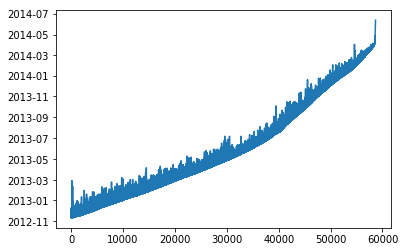

In [21]:
dataset_date_filtered['Move In Date'].plot()

In [22]:
dataset_date_filtered['Move Out Date'].describe()

count                          15321
unique                         15315
top       2013-07-11 12:28:54.500000
freq                               2
first            2012-11-12 22:04:39
last             2014-06-11 10:24:59
Name: Move Out Date, dtype: object

Now date values are within the range

In [23]:

dataset_date_filtered[dataset_date_filtered['Move Out Date'] <dataset_date_filtered['Move In Date']]

,Store,Account ID,SquareFeet,Rented?,ReserveDate,Move In Date,Move Out Date,Promotion Name,Source,RentRate,StreetRate,Concession,Region,Previously Used Storage?,Purpose?,Storage Reason


On checking, if there are any rows with Move Out date earlier than Move In date, No such rows are found.

In [24]:
dataset_date_filtered['Promotion Name'].value_counts()

First Month Free         33292
First Month Half Off      4268
Three Months Half off      670
Two Months Half Off        329
Two Months Free            312
Name: Promotion Name, dtype: int64

In [25]:
dataset_date_filtered['Region'].unique()

array(['Inland Empire', 'Ohio', 'Other Southeast', 'Boston',
       'Southern California', 'Colorado / Utah', 'New York / Northern NJ',
       'Florida Markets - Other', 'Connecticut', 'Other West',
       'Other Northeast', 'Philadelphia / Southern NJ', 'Baltimore / DC',
       'Other Midwest', 'Arizona / Las Vegas', 'Atlanta',
       'Miami / Ft. Lauderdale', 'Texas Markets - Major', 'Tennessee',
       'Chicago'], dtype=object)

Region data is well defined, there are no duplicates due to spelling mistake.

# Predicting length of stay

train data is observations for which Move Out date is known. 

In [26]:
dataset_Rented_True = dataset_date_filtered[dataset_date_filtered['Rented?']==True]
dataset_Rented_True.shape

(36688, 16)

Data which did not result in Rental is removed

In [36]:
dataset_Rented_True_known_stayknown = dataset_Rented_True[~pd.isnull(dataset_Rented_True['Move Out Date'])]

dataset_Rented_True_known_stayknown is training data to train length of stay against other variables

In [37]:
dataset_Rented_True_known_stayunknown = dataset_Rented_True[pd.isnull(dataset_Rented_True['Move Out Date'])]

dataset_Rented_True_known_stayunknown is test data for which length of stay has to be calculated 

In [38]:
dataset_Rented_True_known_stayknown.shape, dataset_Rented_True_known_stayunknown.shape

((15321, 16), (21367, 16))

As train size is relatively smaller than test size, using very complicated model will tend to 'overfit'.

In [40]:
# Calculating length of stay and converting into Month
dataset_Rented_True_known_stayknown['Length_of_stay'] = dataset_Rented_True_known_stayknown.apply(lambda x:  int(np.ceil((x['Move Out Date'] - x['Move In Date'])/np.timedelta64(1, 'M'))), axis=1)

In [41]:
dataset_Rented_True_known_stayknown.head()

,Store,Account ID,SquareFeet,Rented?,ReserveDate,Move In Date,Move Out Date,Promotion Name,Source,RentRate,StreetRate,Concession,Region,Previously Used Storage?,Purpose?,Storage Reason,Length_of_stay
8,3110,105008,50,True,2012-11-11 18:04:13.000,2012-11-11 23:55:14.000,2013-02-07 17:32:44.000,First Month Half Off,Sales Center Reservation,53.1,59.0,-0.1,Colorado / Utah,No,Other,Other,3
10,3325,105010,50,True,2012-11-11 18:16:15.434,2012-11-17 18:17:43.434,2013-10-20 20:30:31.109,NaN,Sales Center Reservation,115.0,115.0,0.0,Florida Markets - Other,Yes,Other,Other,12
17,2570,105017,100,True,2012-11-11 19:37:59.000,2012-12-09 03:16:10.000,2013-05-17 17:02:35.500,First Month Free,Sales Center Reservation,56.7,63.0,-0.1,Other Southeast,No,Organizing / Creating More Living Space,Files / Office Items,6
27,1520,105027,0,True,2012-11-11 20:44:19.856,2012-11-13 00:30:45.856,2013-04-15 19:15:03.214,NaN,Web Reservation,94.0,94.0,0.0,New York / Northern NJ,No,Other,Files / Office Items,6
39,3090,105039,50,True,2012-11-11 22:04:15.000,2012-11-11 22:58:30.000,2012-12-11 09:01:07.500,First Month Free,Store Reservation,35.1,39.0,-0.1,Colorado / Utah,No,Organizing / Creating More Living Space,Files / Office Items,1


In [42]:
dataset_Rented_True_known_stayknown['Length_of_stay'].describe()

count    15321.000000
mean         4.646825
std          2.954529
min          1.000000
25%          2.000000
50%          4.000000
75%          6.000000
max         15.000000
Name: Length_of_stay, dtype: float64

Maximum value of length of stay is 15 only, so model will not predict values above 15 almost most of the time. So these predicted
values for test data can be used as 'incremental stay'. 

In [43]:
Category_Variables = ['Promotion Name','Source','Region','Previously Used Storage?','Purpose?','Storage Reason']

In [44]:
# Checking data leakage, if there is any category which is present in test but not in train data
for cat_var in Category_Variables:
    print(set(dataset_Rented_True_known_stayunknown[~pd.isnull(dataset_Rented_True_known_stayunknown[cat_var])][cat_var].unique())-set(dataset_Rented_True_known_stayknown[~pd.isnull(dataset_Rented_True_known_stayknown[cat_var])][cat_var].unique()))

set()
set()
set()
set()
set()
set()


There are no new categories in test

In [45]:
Features= dataset_Rented_True_known_stayknown[['SquareFeet','Promotion Name','Source','RentRate','Concession','Region','Previously Used Storage?','Purpose?','Storage Reason']]

In [46]:
Features.head()

,SquareFeet,Promotion Name,Source,RentRate,Concession,Region,Previously Used Storage?,Purpose?,Storage Reason
8,50,First Month Half Off,Sales Center Reservation,53.1,-0.1,Colorado / Utah,No,Other,Other
10,50,NaN,Sales Center Reservation,115.0,0.0,Florida Markets - Other,Yes,Other,Other
17,100,First Month Free,Sales Center Reservation,56.7,-0.1,Other Southeast,No,Organizing / Creating More Living Space,Files / Office Items
27,0,NaN,Web Reservation,94.0,0.0,New York / Northern NJ,No,Other,Files / Office Items
39,50,First Month Free,Store Reservation,35.1,-0.1,Colorado / Utah,No,Organizing / Creating More Living Space,Files / Office Items


In [47]:
# Checking Null
Features.isnull().sum().any

<bound method Series.any of SquareFeet                     0
Promotion Name              4304
Source                         0
RentRate                       0
Concession                     0
Region                         0
Previously Used Storage?       0
Purpose?                      19
Storage Reason                10
dtype: int64>

Null values of Purpose? and Storage Reason are filled with Other category and for Promotion those are filled with 'No Promotion'

In [48]:
Features['Purpose?']= Features['Purpose?'].fillna('Other')
Features['Storage Reason']= Features['Storage Reason'].fillna('Other')
Features['Promotion Name']= Features['Promotion Name'].fillna('No Promotion')

In [49]:
# No more nulls
Features.isnull().sum().any

<bound method Series.any of SquareFeet                  0
Promotion Name              0
Source                      0
RentRate                    0
Concession                  0
Region                      0
Previously Used Storage?    0
Purpose?                    0
Storage Reason              0
dtype: int64>

In [50]:
X = pd.get_dummies(Features)

In [51]:
Y = dataset_Rented_True_known_stayknown['Length_of_stay']

In [52]:
X.shape

(15321, 47)

In [53]:
# Data Split
X_train, X_val,Y_train, Y_val = train_test_split(X,Y, test_size= 0.15)

Applying Linear Regression

In [54]:
lm_model = sm.OLS(Y_train, sm.add_constant(X_train)).fit()

In [55]:
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Length_of_stay   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     12.21
Date:                Tue, 29 Oct 2019   Prob (F-statistic):           1.35e-78
Time:                        15:38:16   Log-Likelihood:                -32327.
No. Observations:               13022   AIC:                         6.474e+04
Df Residuals:                   12980   BIC:                         6.505e+04
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
const                                                              2.0667      0.076     27.365      0.000       1.919       2.215
SquareFeet                                                         0.0025      0.001      4.297      0.000       0.001       0.004
RentRate                                                          -0.0044      0.001     -5.124      0.000      -0.006      -0.003
Concession                                                        -0.3559      0.366     -0.971      0.332      -1.074       0.362
Promotion Name_First Month Free                                    0.3027      0.146      2.071      0.038       0.016       0.589
Promotion Name_First Month Half Off                               -0.1377      0.165     -0.832      0.405      -0.462       0.187
Promotion Name_No Promotion                                        1.1911      0.149      8.000      0.000       0.899       1.483
Promotion Name_Two Months Free                                     0.1507      0.566      0.266      0.790      -0.958       1.259
Promotion Name_Two Months Half Off                                 0.5600      0.312      1.794      0.073      -0.052       1.172
Source_Sales Center Reservation                                    0.8754      0.052     16.824      0.000       0.773       0.977
Source_Store Reservation                                           0.5602      0.054     10.418      0.000       0.455       0.666
Source_Web Reservation                                             0.6312      0.044     14.317      0.000       0.545       0.718
Region_Arizona / Las Vegas                                        -0.1140      0.087     -1.307      0.191      -0.285       0.057
Region_Atlanta                                                     0.1246      0.085      1.464      0.143      -0.042       0.291
Region_Baltimore / DC                                             -0.2534      0.168     -1.505      0.132      -0.583       0.077
Region_Boston                                                      0.1462      0.136      1.075      0.282      -0.120       0.413
Region_Chicago                                                    -0.3828      0.233     -1.646      0.100      -0.839       0.073
Region_Colorado / Utah                                             0.3892      0.085      4.586      0.000       0.223       0.556
Region_Connecticut                                                 0.0999      0.120      0.832      0.406      -0.136       0.335
Region_Florida Markets - Other                                     0.2611      0.127      2.048      0.041       0.011       0.511
Region_Inland Empire                                               0.0

Adjust R sqaure is very low, looks like given predictors are not sufficient in predicting length of stay. So, 
lenght of stay is mostly like an average value with high dependence on intercept. It is also anti-corelated with Rent Rate while concession is not coming statistically significant variable.

In [56]:
# Checking performance on validation set
Y_pred_val = lm_model.predict(sm.add_constant(X_val))
mean_squared_error(Y_val,Y_pred_val )

8.371609948995335

As there are many categorical variable, tree methods can be useful. Trying Random Forest and Xgboost:

In [57]:
rcf = RandomForestRegressor(random_state=42)
rcf.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [58]:
Y_pred_rcf = rcf.predict(X_val)
mean_squared_error(Y_val,Y_pred_rcf )

9.981756113999417

In [59]:
XGB = XGBRegressor(random_state=42)
Xgb_model = XGB.fit(X_train, Y_train)

In [60]:
Y_pred_xgb = Xgb_model.predict(X_val)
mean_squared_error(Y_val,Y_pred_xgb )

8.165257411141015

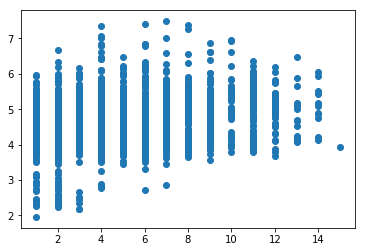

In [61]:
plt.scatter(Y_val, Y_pred_xgb)

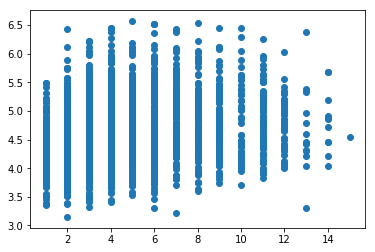

In [62]:
plt.scatter(Y_val, Y_pred_val)

Performance in Xgboost and Linear Regression is almost similar, going with simpler model: Linear Regression due to less train data

Training on overall data, including validation set:

In [63]:
lm_model_final = sm.OLS(Y, sm.add_constant(X)).fit()

In [64]:
unknown_data_features = dataset_Rented_True_known_stayunknown[['SquareFeet','Promotion Name','Source','RentRate','Concession','Region','Previously Used Storage?','Purpose?','Storage Reason']]

In [65]:
unknown_data_features.isnull().sum().any

<bound method Series.any of SquareFeet                     0
Promotion Name              6974
Source                         0
RentRate                       0
Concession                     0
Region                         0
Previously Used Storage?       0
Purpose?                      16
Storage Reason                25
dtype: int64>

filling null values in same way

In [66]:
unknown_data_features['Purpose?']= unknown_data_features['Purpose?'].fillna('Other')
unknown_data_features['Storage Reason']= unknown_data_features['Storage Reason'].fillna('Other')
unknown_data_features['Promotion Name']= unknown_data_features['Promotion Name'].fillna('No Promotion')

In [67]:
X_test = pd.get_dummies(unknown_data_features)

In [68]:
Y_pred_test = lm_model_final.predict(sm.add_constant(X_test))

In [69]:
Y_pred_test.describe()

count    21367.000000
mean         4.711286
std          0.588102
min          2.766813
25%          4.292534
50%          4.671901
75%          5.135022
max          6.992924
dtype: float64

As expected predicted values are in range of 2-7 months, having values nearby mean. If demographic, income and past rental information were known,
range can be improved, giving us better idea of incremental stay

In [70]:
dataset_Rented_True_known_stayunknown['predicted_stay_by_model'] = pd.Series(Y_pred_test)

calculating months which are stayed already in test data:

In [71]:
dataset_Rented_True_known_stayunknown['stayed_already']= dataset_Rented_True_known_stayunknown.apply(lambda x:  int(np.ceil((pd.datetime(2014,11,6) - x['Move In Date'])/np.timedelta64(1, 'M'))), axis=1)

In [72]:
dataset_Rented_True_known_stayunknown.head()

,Store,Account ID,SquareFeet,Rented?,ReserveDate,Move In Date,Move Out Date,Promotion Name,Source,RentRate,StreetRate,Concession,Region,Previously Used Storage?,Purpose?,Storage Reason,predicted_stay_by_model,stayed_already
3,1615,105003,300,True,2012-11-11 17:05:25.627,2012-11-11 17:05:27.627,NaT,NaN,Web Reservation,224.0,224.0,0.0,Inland Empire,No,Other,Other,5.271033,24
24,2715,105024,25,True,2012-11-11 20:32:25.000,2012-11-12 02:42:42.000,NaT,First Month Free,Sales Center Reservation,58.0,58.0,0.0,Baltimore / DC,Yes,Other,Files / Office Items,4.234080,24
30,2800,105030,25,True,2012-11-11 20:59:47.000,2012-11-11 23:21:41.000,NaT,First Month Half Off,Sales Center Reservation,75.6,84.0,-0.1,Ohio,No,Moving (includes college & military deployment),Furniture / Household goods / Appliances,4.392319,24
40,2870,105040,50,True,2012-11-11 22:09:59.000,2012-11-12 02:53:37.000,NaT,First Month Free,Sales Center Reservation,34.2,38.0,-0.1,New York / Northern NJ,Yes,"Recently Acquired Items (inheritance, purchase...",Files / Office Items,4.617081,24
42,2725,105042,100,True,2012-11-11 22:18:43.000,2012-11-11 23:03:57.000,NaT,First Month Half Off,Sales Center Reservation,125.1,139.0,-0.1,Southern California,No,Organizing / Creating More Living Space,Other,4.135700,24


Checking plot of # of months already stayed against values predicted by model 

[]

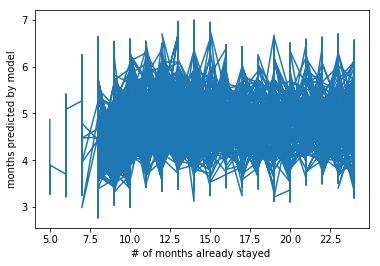

In [75]:
plt.plot(dataset_Rented_True_known_stayunknown['stayed_already'],dataset_Rented_True_known_stayunknown['predicted_stay_by_model'])
plt.xlabel("# of months already stayed ")
plt.ylabel("months predicted by model")
plt.plot()

Length of stay  =  months already stayed + additional stay predicted by model

In [76]:
dataset_Rented_True_known_stayunknown['Length_of_stay'] = dataset_Rented_True_known_stayunknown.apply(lambda x: int(np.ceil(x['predicted_stay_by_model'])+ x['stayed_already']), axis=1)

In [77]:
dataset_Rented_True_known_stayunknown.head()

,Store,Account ID,SquareFeet,Rented?,ReserveDate,Move In Date,Move Out Date,Promotion Name,Source,RentRate,StreetRate,Concession,Region,Previously Used Storage?,Purpose?,Storage Reason,predicted_stay_by_model,stayed_already,Length_of_stay
3,1615,105003,300,True,2012-11-11 17:05:25.627,2012-11-11 17:05:27.627,NaT,NaN,Web Reservation,224.0,224.0,0.0,Inland Empire,No,Other,Other,5.271033,24,30
24,2715,105024,25,True,2012-11-11 20:32:25.000,2012-11-12 02:42:42.000,NaT,First Month Free,Sales Center Reservation,58.0,58.0,0.0,Baltimore / DC,Yes,Other,Files / Office Items,4.234080,24,29
30,2800,105030,25,True,2012-11-11 20:59:47.000,2012-11-11 23:21:41.000,NaT,First Month Half Off,Sales Center Reservation,75.6,84.0,-0.1,Ohio,No,Moving (includes college & military deployment),Furniture / Household goods / Appliances,4.392319,24,29
40,2870,105040,50,True,2012-11-11 22:09:59.000,2012-11-12 02:53:37.000,NaT,First Month Free,Sales Center Reservation,34.2,38.0,-0.1,New York / Northern NJ,Yes,"Recently Acquired Items (inheritance, purchase...",Files / Office Items,4.617081,24,29
42,2725,105042,100,True,2012-11-11 22:18:43.000,2012-11-11 23:03:57.000,NaT,First Month Half Off,Sales Center Reservation,125.1,139.0,-0.1,Southern California,No,Organizing / Creating More Living Space,Other,4.135700,24,29


In [78]:
# Dropping extra columns
dataset_Rented_True_known_stayunknown = dataset_Rented_True_known_stayunknown.drop(['predicted_stay_by_model','stayed_already'],axis=1)

In [79]:
dataset_Rented_True_known_stayunknown.shape, dataset_Rented_True_known_stayknown.shape

((21367, 17), (15321, 17))

Now we can combine both data set as we know length of stay for each observation within rental-converted data

In [80]:
dataset_combined_for_rented  =  pd.concat ([dataset_Rented_True_known_stayknown, dataset_Rented_True_known_stayunknown], axis=0)

# Question 1

In [81]:
def cost_per_observation(x):
    
    if pd.isnull(x['Promotion Name']):
        return 0
    if x['Promotion Name'] =='First Month Free':
        return x['RentRate']
    if x['Promotion Name'] =='First Month Half Off':
        return  x['RentRate']/2
    if x['Promotion Name'] =='Two Months Free':
        if x['Length_of_stay']>1:
            return  2*x['RentRate']
        else:
            return  x['RentRate']

    if x['Promotion Name'] =='Two Months Half Off': 
        if x['Length_of_stay']>=2:
            return  x['RentRate']
        else :
            return  x['RentRate']/2
        
    if x['Promotion Name'] =='Three Months Half off':
        if x['Length_of_stay']>=3:
            return  3*x['RentRate']/2
        elif x['Length_of_stay']==2:
            return x['RentRate']
        else:
            return x['RentRate']/2

Above function will return cost of promotion for each observation based on Type of promotion and Length of stay. We assumed that customer will at start of each month depending upon type of promotion. E.g. Three Months Half Off means he will pay half of rent for fist 3 months

In [82]:
dataset_combined_for_rented['cost_by_company'] = dataset_combined_for_rented.apply(cost_per_observation,axis=1)

In [83]:
dataset_combined_for_rented.head()

,Store,Account ID,SquareFeet,Rented?,ReserveDate,Move In Date,Move Out Date,Promotion Name,Source,RentRate,StreetRate,Concession,Region,Previously Used Storage?,Purpose?,Storage Reason,Length_of_stay,cost_by_company
8,3110,105008,50,True,2012-11-11 18:04:13.000,2012-11-11 23:55:14.000,2013-02-07 17:32:44.000,First Month Half Off,Sales Center Reservation,53.1,59.0,-0.1,Colorado / Utah,No,Other,Other,3,26.55
10,3325,105010,50,True,2012-11-11 18:16:15.434,2012-11-17 18:17:43.434,2013-10-20 20:30:31.109,NaN,Sales Center Reservation,115.0,115.0,0.0,Florida Markets - Other,Yes,Other,Other,12,0.00
17,2570,105017,100,True,2012-11-11 19:37:59.000,2012-12-09 03:16:10.000,2013-05-17 17:02:35.500,First Month Free,Sales Center Reservation,56.7,63.0,-0.1,Other Southeast,No,Organizing / Creating More Living Space,Files / Office Items,6,56.70
27,1520,105027,0,True,2012-11-11 20:44:19.856,2012-11-13 00:30:45.856,2013-04-15 19:15:03.214,NaN,Web Reservation,94.0,94.0,0.0,New York / Northern NJ,No,Other,Files / Office Items,6,0.00
39,3090,105039,50,True,2012-11-11 22:04:15.000,2012-11-11 22:58:30.000,2012-12-11 09:01:07.500,First Month Free,Store Reservation,35.1,39.0,-0.1,Colorado / Utah,No,Organizing / Creating More Living Space,Files / Office Items,1,35.10


Total cost incurred by company in Promotions is sum over all these rows, as non-promotion has 0 cost

In [84]:
total_cost_by_company = np.sum(dataset_combined_for_rented['cost_by_company'])

In [85]:
total_cost_by_company

2223112.005

As Length of stay is not the number of months customer pays for storage, I am defining a new variable 'Pay Period' which subtracts effective free number of months from Length of stay to help us calculate revenue for each observation.

Pay Period also uses Promotion type and Length of stay to get final effective pay months.Pay Period can be fractional as well for First Month Half Off, Two Months Half Off and Three Months Half off

In [86]:
def payPeriod_per_observation(x):
    
    if pd.isnull(x['Promotion Name']):
        return x['Length_of_stay']
    if x['Promotion Name'] =='First Month Free':
        return x['Length_of_stay'] -1
    if x['Promotion Name'] =='First Month Half Off':
        return  x['Length_of_stay'] -0.5
    if x['Promotion Name'] =='Two Months Free':
        if x['Length_of_stay']>1:
            return  x['Length_of_stay'] -2
        else:
            return  0
    if x['Promotion Name'] =='Two Months Half Off': 
        if x['Length_of_stay']>=2:
            return  x['Length_of_stay'] -1
        else :
            return  0.5
        
    if x['Promotion Name'] =='Three Months Half off':
        if x['Length_of_stay']>=3:
            return  x['Length_of_stay'] -1.5
        elif x['Length_of_stay']==2:
            return 1
        else:
            return 0.5

In [87]:
dataset_combined_for_rented['PayPeriod'] = dataset_combined_for_rented.apply(payPeriod_per_observation,axis=1)

In [88]:
promotion_rented_dataset = dataset_combined_for_rented[~pd.isnull(dataset_combined_for_rented['Promotion Name'])]

promotion_rented_dataset is data for which clients were given promotion and got converted to Rentals

In [89]:
np.sum(promotion_rented_dataset['cost_by_company'])

2223112.005

In [90]:
promotion_rented_dataset.shape, dataset_combined_for_rented.shape

((25410, 19), (36688, 19))

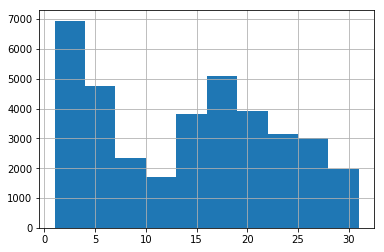

In [91]:
dataset_combined_for_rented['Length_of_stay'].hist()

Total_cost_by_company = Extra Rental Required  $* avg Rental Rate *$  avg Pay Period(in months)

In [92]:
# Getting average values
avg_price = np.mean(promotion_rented_dataset['RentRate'])
avg_Pay_period = np.mean(promotion_rented_dataset['PayPeriod'])

In [93]:
# Using formula above to get additional rentals needed
Extra_rental_volume =  total_cost_by_company/(avg_price *avg_Pay_period )

In [94]:
Extra_rental_volume

1966.486678220522

In [95]:
avg_price, avg_Pay_period

(93.37989334907024, 12.106454151908697)

We will need additional 1967 people who pays rent of 93.38 for a period of 12 months to recover this free promotion

Assuming uniform conversion along the observations, Rent ratio is number of request converted to rental against total requests

In [96]:
Rent_ratio =  dataset_date_filtered[dataset_date_filtered['Rented?']==True].shape[0]/ dataset_date_filtered.shape[0]

In [97]:
Rent_ratio

0.6254560332776433

In [98]:
Extra_Reservation_Volume = Extra_rental_volume/Rent_ratio

In [99]:
Extra_Reservation_Volume

3144.0845936289625

 So , we need to book 3145 more reservation to cover up the cost of promotion

 # Question 2

# does giving promotion make sense overall?

In [100]:
NonPromotion_rented_dataset = dataset_combined_for_rented[pd.isnull(dataset_combined_for_rented['Promotion Name'])]

NonPromotion_rented_dataset is data for which no promotion was given and converted to rentals

Revenue = Rent Rate * Pay Period

In [101]:
promotion_rented_dataset['Revenue_per_customer'] = promotion_rented_dataset['RentRate'] * promotion_rented_dataset['PayPeriod']

In [102]:
NonPromotion_rented_dataset['Revenue_per_customer'] = NonPromotion_rented_dataset['RentRate'] * NonPromotion_rented_dataset['PayPeriod']

In [103]:
Total_revenue_Promotion = np.sum(promotion_rented_dataset['Revenue_per_customer'])

In [104]:
Total_revenue_NonPromotion = np.sum(NonPromotion_rented_dataset['Revenue_per_customer'])

In [105]:
Total_revenue_Promotion , Total_revenue_NonPromotion

(27994928.355, 17638648.72)

Total_revenue_Promotion > Total_revenue_NonPromotion

So, company is generating additional revenue using promotion

In [106]:
Incremental_Revenue_by_Promotion = Total_revenue_Promotion - Total_revenue_NonPromotion

In [107]:
Incremental_Revenue_by_Promotion

10356279.635000002

But, is it justified to give promotions to these many customers? Can we predict based on customer attributes whether company should give promotion or not to that customer?

Let's define a binary variable assessing if a customer is sticky to a place or not?


# Finding sticky and non-sticky customers

The customer who did not use promotion and rented the storage are sticky while customers who used promotion and left immediately using free storage are non-sticky.

We can identify non-sticky customer directly by ones having PayPeriod 0. 

In [108]:
np.sum(dataset_combined_for_rented['PayPeriod']==0)

1132

In [109]:
NonPromotion_rented_dataset.shape

(11278, 20)

In [110]:
non_sticky = dataset_combined_for_rented[dataset_combined_for_rented['PayPeriod']==0][['SquareFeet','PayPeriod','Source','RentRate','Concession','Region','Previously Used Storage?','Purpose?','Storage Reason']]

In [111]:
non_sticky['is_sticky'] = 0

In [112]:
sticky = NonPromotion_rented_dataset[['SquareFeet','PayPeriod','Source','RentRate','Concession','Region','Previously Used Storage?','Purpose?','Storage Reason']]

In [113]:
sticky['is_sticky'] = 1

In [114]:
sticky.head()

,SquareFeet,PayPeriod,Source,RentRate,Concession,Region,Previously Used Storage?,Purpose?,Storage Reason,is_sticky
10,50,12.0,Sales Center Reservation,115.0,0.0,Florida Markets - Other,Yes,Other,Other,1
27,0,6.0,Web Reservation,94.0,0.0,New York / Northern NJ,No,Other,Files / Office Items,1
43,0,5.0,Store Reservation,36.0,-0.2,Inland Empire,Yes,"Recently Acquired Items (inheritance, purchase...",Business Inventory / Product,1
59,90,4.0,Web Reservation,121.0,0.0,Inland Empire,No,Organizing / Creating More Living Space,Other,1
110,100,7.0,Store Reservation,98.4,-0.2,Inland Empire,Yes,Organizing / Creating More Living Space,Other,1


Shuffling the data to make sure there is no pattern

In [116]:
Stick_Check_Data = shuffle(pd.concat([non_sticky,sticky],axis=0))

In [117]:
Stick_Check_Data.shape

(12410, 10)

In [118]:
s_Features = Stick_Check_Data.drop('is_sticky',axis=1)

In [119]:
s_Features_dummies = pd.get_dummies(s_Features)

In [120]:
s_X_train, s_X_val, s_Y_train, s_Y_val = train_test_split(s_Features_dummies,Stick_Check_Data['is_sticky'], test_size=0.10 )

Using logistic Regression with penalty as train size is relatively less to avoid overfitting

In [121]:
lg_model = LogisticRegression(class_weight  = 'balanced', C=0.1)

In [122]:
lg_model.fit(s_X_train,s_Y_train )

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [123]:
# The function will give p value for estimators
def logit_pvalue(model, x):

    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 -  norm.cdf(abs(t))) * 2
    return p

In [124]:
logit_pvalue(lg_model, s_X_train)

array([       nan, 0.83597479, 0.        , 0.06289138, 0.92216825,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.98799031, 0.98421871, 0.96551242, 0.982942  , 0.96376868,
       0.99383428, 0.99581891, 0.99824899, 0.99763269, 0.9983524 ,
       0.99172586, 0.99829874, 0.99013361, 0.99570464])

Most of the variables are not significant so we need better predictors for classification. For now, predicting with this model:

In [125]:
len(lg_model.coef_[0]), len(s_X_val.columns)

(43, 43)

In [126]:
lg_model.intercept_

array([-1.69512546])

In [127]:
# Checking coefficient values
for i in range( len(s_X_val.columns)):
    print(s_X_val.columns[i], lg_model.coef_[0][i])

SquareFeet 0.0007977379595144257
PayPeriod 3.7762111644542644
RentRate -0.01072004228672498
Concession 0.2858125590339708
Source_Sales Center Reservation -0.7859570604822343
Source_Store Reservation -0.09813782941815866
Source_Web Reservation -0.8110305668149863
Region_Arizona / Las Vegas -0.06907444044023128
Region_Atlanta -0.20999660575440876
Region_Baltimore / DC -0.03941249851115957
Region_Boston -0.08005102643327423
Region_Chicago -0.055015728710386715
Region_Colorado / Utah -0.09984345682899111
Region_Connecticut -0.11393071002530977
Region_Florida Markets - Other -0.08011694761038318
Region_Inland Empire -0.17224092249030057
Region_Miami / Ft. Lauderdale -0.05296559611696014
Region_New York / Northern NJ 0.09548027587403551
Region_Ohio -0.07078283865804916
Region_Other Midwest -0.1215066838734811
Region_Other Northeast -0.2112728911913243
Region_Other Southeast -0.03653186305531167
Region_Other West -0.1257981092504354
Region_Philadelphia / Southern NJ -0.09749727530013179
Regio

In [128]:
# Predicting on validation data
lg_pred = lg_model.predict(s_X_val)

In [129]:
confusion_matrix(s_Y_val, lg_pred)

array([[ 105,    0],
       [   4, 1132]], dtype=int64)

In [130]:
roc_auc_score(s_Y_val, lg_pred)

0.9982394366197183

Checking values with Cross Validation:

In [131]:
lg_cv = LogisticRegression(class_weight  = 'balanced', C=0.1)

In [132]:
cross_val_score(lg_cv, s_Features_dummies,Stick_Check_Data['is_sticky'], cv=3)

array([0.99903335, 0.99806576, 0.99734043])

Current Classifier looks great, although there is lot of scope to try other models and perform parameter tuning. 
For now, I am using Logistic Regression with penality model. Training on overall data:

In [133]:
lg_model_final =LogisticRegression(class_weight  = 'balanced', C=0.1)
lg_model_final.fit(s_Features_dummies,Stick_Check_Data['is_sticky'] )

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

Creating test data set: observations which are rented, used promotion and stayed after free trial

In [134]:
Promotion_Rented_Stayed_PostFree_Dataset = promotion_rented_dataset[promotion_rented_dataset['PayPeriod']!=0]

In [135]:
s_X_test = Promotion_Rented_Stayed_PostFree_Dataset[['SquareFeet','PayPeriod','Source','RentRate','Concession','Region','Previously Used Storage?','Purpose?','Storage Reason']]

In [136]:
s_X_test_dummies = pd.get_dummies(s_X_test)

In [137]:
lg_pred_test = lg_model_final.predict(s_X_test_dummies)

In [138]:
np.sum(lg_pred_test==0), np.sum(lg_pred_test==1)

(2756, 21522)

In [139]:
Promotion_Rented_Stayed_PostFree_Dataset['is_sticky']  = pd.Series(lg_pred_test)

In [140]:
Promotion_Rented_Stayed_PostFree_Dataset[Promotion_Rented_Stayed_PostFree_Dataset['is_sticky']==0].head()

,Store,Account ID,SquareFeet,Rented?,ReserveDate,Move In Date,Move Out Date,Promotion Name,Source,RentRate,...,Concession,Region,Previously Used Storage?,Purpose?,Storage Reason,Length_of_stay,cost_by_company,PayPeriod,Revenue_per_customer,is_sticky
62,2555,105062,150,True,2012-11-11 23:28:23,2012-11-11 23:31:55,2013-01-11 21:47:31.000,First Month Free,Web Reservation,152.1,...,-0.1,New York / Northern NJ,Yes,Other,Other,3,152.1,2.0,304.2,0.0
83,2800,105083,50,True,2012-11-12 00:54:57,2012-11-12 00:54:59,2013-04-07 10:10:54.500,First Month Half Off,Web Reservation,159.0,...,0.0,Ohio,No,"Recently Acquired Items (inheritance, purchase...",Files / Office Items,5,79.5,4.5,715.5,0.0
120,3845,105120,200,True,2012-11-12 02:53:57,2012-11-17 03:19:40,2013-04-06 10:27:49.000,First Month Free,Sales Center Reservation,162.0,...,-0.1,Connecticut,No,"Recently Acquired Items (inheritance, purchase...",Other,5,162.0,4.0,648.0,0.0
150,1555,105150,200,True,2012-11-12 04:17:47,2012-11-12 04:50:29,2013-08-09 22:45:17.000,First Month Free,Web Reservation,269.0,...,0.0,Ohio,Yes,Organizing / Creating More Living Space,Other,9,269.0,8.0,2152.0,0.0
154,2800,105154,25,True,2012-11-12 04:22:35,2012-11-12 04:22:39,2013-03-24 23:02:48.000,First Month Half Off,Web Reservation,39.0,...,0.0,Ohio,No,Other,Files / Office Items,5,19.5,4.5,175.5,0.0


Now, we can say that additional revenue generated due to Promotion is actually because of the customers which were originally Non-sticky but due to promotion, stayed with the company.

In [141]:
Actual_Additional_Revenue = np.sum(Promotion_Rented_Stayed_PostFree_Dataset[Promotion_Rented_Stayed_PostFree_Dataset['is_sticky']==0]['Revenue_per_customer'])

In [142]:
Actual_Additional_Revenue

1003170.35

In [143]:
Actual_Additional_Revenue - total_cost_by_company

-1219941.6549999998

 We are giving promotion to 24278 while it will be best to give promotion to only 2756 people, so Although it seems that we are 
 earning extra revenue of 10356279 while we are only earning 1003170(one tenth of earlier) by promotion.
 Considering the cost by promotion, we are actually losing money 1219941 $ by current promotion model. So company should assess its strategy of giving promotion and should identify sticky customer.

# Effect of Length of stay

On Extra Rentals:

Extra Rentals = Total Promotion Cost / ( Avg Rate Rate  * Avg Pay Period) 
Pay Period  = Length of stay - k , where k is a small number depending upon promotion
Clearly, Higher Length of stay will result in Higher Pay Period and there will be lesser Extra Rentals Needed.

On Additional Revenue due to Promotion:

Additional Revenue are getting generated by giving promotion to non-sticky customers. How is Avg length of stay different in predicted sticky and non-sticky customers?
    

In [144]:
Avg_length_for_correct_promotion = np.mean(Promotion_Rented_Stayed_PostFree_Dataset[Promotion_Rented_Stayed_PostFree_Dataset['is_sticky']==0]['Length_of_stay'])

In [145]:
Avg_length_for_wrong_promotion = np.mean(Promotion_Rented_Stayed_PostFree_Dataset[Promotion_Rented_Stayed_PostFree_Dataset['is_sticky']==1]['Length_of_stay'])

In [146]:
Avg_length_for_correct_promotion,Avg_length_for_wrong_promotion 

(15.1419185282523, 14.990009668063164)

Applying t test to assess difference in mean of length of stay:

In [147]:
ttest_ind(Promotion_Rented_Stayed_PostFree_Dataset[Promotion_Rented_Stayed_PostFree_Dataset['is_sticky']==0]['Length_of_stay'], Promotion_Rented_Stayed_PostFree_Dataset[Promotion_Rented_Stayed_PostFree_Dataset['is_sticky']==1]['Length_of_stay'])

Ttest_indResult(statistic=0.36829585979751434, pvalue=0.7126638319971456)

As p value is high, we can say that means are not different from each other in both cases.

If we see in distribution, we can say, ultimately there are few customers who are converting in long-term stay if they pass first 10 months or so. 

With a different model,result may vary too. 

Text(0.5,1,'Distribution of Length of stay for Non-sticky customers')

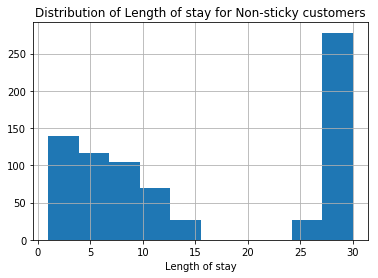

In [148]:
Promotion_Rented_Stayed_PostFree_Dataset[Promotion_Rented_Stayed_PostFree_Dataset['is_sticky']==0]['Length_of_stay'].hist()
plt.xlabel("Length of stay")
plt.title("Distribution of Length of stay for Non-sticky customers")

#  Effect by Customer type

Effect_on_Cost function:

1.Checks effect by each category of a variable on Total Cost of Promotion, 

2.Confirms the variability by either t-test or ANOVA 

3.Finds extra rentals needed for each category

Input: Categorical variable whose effect to check

Output: Dictionary for extra rentals, Dictionary for Total cost, Dictionary for avg cost, stat value, p value

In [149]:
def Effect_on_Cost(Variable):
    categories = promotion_rented_dataset[~pd.isnull(promotion_rented_dataset[Variable])][Variable].unique()
    list_of_costs =[]
    
    gb = promotion_rented_dataset.groupby(Variable)['cost_by_company']
    gb_price =  promotion_rented_dataset.groupby(Variable)['RentRate'].mean()
    gb_stay = promotion_rented_dataset.groupby(Variable)['PayPeriod'].mean()
    Extra_Rentals = []
    Total_Costs=[]
    Avg_Cost=[]
    for i,category in enumerate(categories):
        arr = gb.get_group(category)
        list_of_costs.append(arr)
        Total_Costs.append(np.sum(arr))
        Avg_Cost.append(np.mean(arr))
        Extra_Rentals.append(np.sum(arr)/(gb_price[i]*gb_stay[i]))
    if len(categories) ==2:
        t_val, p_val = ttest_ind(list_of_costs[0], list_of_costs[1])
        stat_val = t_val
        
    else:
        f_val,p_val = f_oneway(*list_of_costs)
        stat_val = f_val
        
    return dict(zip(categories,Extra_Rentals )),dict(zip(categories,Total_Costs )),dict(zip(categories,Avg_Cost) ), stat_val, p_val    

Effect_on_Revenue function:

1.Checks effect by each category of a variable on Additional Renenue generated by giving promotion to correct customers, 

2.Confirms the variability by either t-test or ANOVA 


Input: Categorical variable whose effect to check

Output: Dictionary for Additional Revenue, Dictionary for Additional Average Revenue, stat value, p value

In [150]:
def Effect_on_Revenue(Variable):
    categories = Promotion_Rented_Stayed_PostFree_Dataset[~pd.isnull(promotion_rented_dataset[Variable])][Variable].unique()
    list_of_revenue =[]
    Avg_of_revenue=[]
    Net_Avg_Revenue = []
    _,Total_Cost_Category,_,_,_ = Effect_on_Cost(Variable)
    #Revenue generated by using promotion
    gb = Promotion_Rented_Stayed_PostFree_Dataset[Promotion_Rented_Stayed_PostFree_Dataset['is_sticky']==0].groupby(Variable)['Revenue_per_customer']
    
    for i,category in enumerate(categories):
        arr = gb.get_group(category)
        list_of_revenue.append(arr)
        Avg_of_revenue.append(np.mean(arr))
        Net_Avg_Revenue.append(np.mean(np.sum(arr) -Total_Cost_Category[category]) )
        
    if len(categories) ==2:
        t_val, p_val = ttest_ind(list_of_revenue[0], list_of_revenue[1])
        return dict(zip(categories,Avg_of_revenue )),dict(zip(categories,Net_Avg_Revenue )), t_val, p_val
    else:
        f_val,p_val = f_oneway(*list_of_revenue)
        return dict(zip(categories,Avg_of_revenue )),dict(zip(categories,Net_Avg_Revenue )), f_val, p_val

Effect of Previously used stores

In [151]:
Effect_on_Cost('Previously Used Storage?')

({'No': 950.4741537949926, 'Yes': 1016.8425493357402},
 {'No': 1023684.0249999999, 'Yes': 1199427.9800000002},
 {'No': 85.16506031614051, 'Yes': 89.5763988050767},
 -6.802064209442916,
 1.0541823145680924e-11)

In [152]:
Effect_on_Revenue('Previously Used Storage?')

({'No': 1171.1445530726253, 'Yes': 1448.884863523573},
 {'No': -604414.2749999999, 'Yes': -615527.3800000002},
 -2.696766815027266,
 0.007156881848289449)

Customers who have used storage before tends to be costly and but also generates more revenue, identifying non-sticky returning customers will help in reducing cost.

Effect of Purpose?

In [153]:
Effect_on_Cost('Purpose?')

({'Other': 335.30940876791306,
  'Organizing / Creating More Living Space': 593.5748321352128,
  'Recently Acquired Items (inheritance, purchase, etc.)': 486.4687433172473,
  'Business Purposes': 117.42639733808629,
  'Seasonal Storage': 70.87299766589348,
  'Moving (includes college & military deployment)': 164.3355839702423,
  'Remodeling / Renovating': 56.89934344252341},
 {'Other': 358417.30000000005,
  'Organizing / Creating More Living Space': 859299.95,
  'Recently Acquired Items (inheritance, purchase, etc.)': 525175.26,
  'Business Purposes': 134034.925,
  'Seasonal Storage': 76829.69499999999,
  'Moving (includes college & military deployment)': 195505.75,
  'Remodeling / Renovating': 71787.92499999999},
 {'Other': 76.74888650963729,
  'Organizing / Creating More Living Space': 89.1205092304508,
  'Recently Acquired Items (inheritance, purchase, etc.)': 86.23567487684853,
  'Business Purposes': 84.03443573667671,
  'Seasonal Storage': 98.24769181585654,
  'Moving (includes co

In [154]:
Effect_on_Revenue('Purpose?')

({'Other': 1463.756439393939,
  'Organizing / Creating More Living Space': 1241.2339655172411,
  'Recently Acquired Items (inheritance, purchase, etc.)': 1195.5105527638195,
  'Business Purposes': 1344.9724999999999,
  'Seasonal Storage': 1391.678260869565,
  'Moving (includes college & military deployment)': 1710.0396226415094,
  'Remodeling / Renovating': 1421.9386363636365},
 {'Other': -165201.45000000007,
  'Organizing / Creating More Living Space': -499342.0999999999,
  'Recently Acquired Items (inheritance, purchase, etc.)': -287268.66,
  'Business Purposes': -80236.025,
  'Seasonal Storage': -44821.094999999994,
  'Moving (includes college & military deployment)': -104873.65000000001,
  'Remodeling / Renovating': -40505.27499999999},
 1.3266128376749027,
 0.24261632900748367)

Remodeling / Renovating is most profitable category in Purpose 

Effect of Storage Reason

In [155]:
Effect_on_Cost('Storage Reason')

({'Other': 1174.4472880785079,
  'Files / Office Items': 304.1179032197779,
  'Yard Equipment / Tools': 89.19940289834182,
  'Business Inventory / Product': 163.53566776975924,
  'Furniture / Household goods / Appliances': 32.78558714223143,
  'Auto / Motorcycle / Boat': 49.723981126653214,
  'Clothes / Toys / Miscellaneous': 81.03211193965498},
 {'Other': 1425134.435,
  'Files / Office Items': 324412.67000000004,
  'Yard Equipment / Tools': 135919.75,
  'Business Inventory / Product': 145902.275,
  'Furniture / Household goods / Appliances': 42209.0,
  'Auto / Motorcycle / Boat': 58766.85,
  'Clothes / Toys / Miscellaneous': 88570.04999999999},
 {'Other': 91.33720662692468,
  'Files / Office Items': 68.92132356065517,
  'Yard Equipment / Tools': 83.3352237890862,
  'Business Inventory / Product': 98.71601826792933,
  'Furniture / Household goods / Appliances': 81.95922330097089,
  'Auto / Motorcycle / Boat': 88.23851351351362,
  'Clothes / Toys / Miscellaneous': 112.97200255102005},
 

In [156]:
Effect_on_Revenue('Storage Reason')

({'Other': 1375.409406952964,
  'Files / Office Items': 976.24598540146,
  'Yard Equipment / Tools': 1588.996226415094,
  'Business Inventory / Product': 1359.361842105263,
  'Furniture / Household goods / Appliances': 1293.6615384615384,
  'Auto / Motorcycle / Boat': 1114.9045454545453,
  'Clothes / Toys / Miscellaneous': 1594.7675},
 {'Other': -752559.235,
  'Files / Office Items': -190666.97000000003,
  'Yard Equipment / Tools': -51702.95000000001,
  'Business Inventory / Product': -94246.525,
  'Furniture / Household goods / Appliances': -25391.4,
  'Auto / Motorcycle / Boat': -46502.9,
  'Clothes / Toys / Miscellaneous': -56674.69999999999},
 1.9515155453396993,
 0.07025164449012747)

Furniture / Household goods / Appliances, Yard Equipment / Tools are high profit Storage Reason categories while Business Inventory / Product
 are least performing.


Effect of  Region

In [157]:
Effect_on_Cost('Region')

({'Colorado / Utah': 183.58154700793366,
  'Other Southeast': 36.12943994329893,
  'Southern California': 74.69772892394064,
  'Boston': 78.37470682988835,
  'Inland Empire': 191.23360591896255,
  'New York / Northern NJ': 67.41436092907588,
  'Florida Markets - Other': 81.48758769203339,
  'Other Midwest': 93.15728923558268,
  'Arizona / Las Vegas': 209.18051595370446,
  'Ohio': 185.23689012976715,
  'Atlanta': 152.40736356050047,
  'Texas Markets - Major': 39.294544583896254,
  'Connecticut': 115.34212769284926,
  'Miami / Ft. Lauderdale': 135.35957839340682,
  'Tennessee': 57.72410423699322,
  'Other Northeast': 80.10120058435933,
  'Baltimore / DC': 53.54002563224712,
  'Other West': 48.61795024479111,
  'Chicago': 27.082482896817133,
  'Philadelphia / Southern NJ': 57.972537021873336},
 {'Colorado / Utah': 227536.75,
  'Other Southeast': 30817.174999999996,
  'Southern California': 73036.14,
  'Boston': 121322.33,
  'Inland Empire': 253730.35499999998,
  'New York / Northern NJ': 

In [158]:
Effect_on_Revenue('Region')

({'Colorado / Utah': 1422.3246666666666,
  'Other Southeast': 1311.6818181818182,
  'Southern California': 1402.72,
  'Boston': 1699.5776315789474,
  'Inland Empire': 1473.5012048192773,
  'New York / Northern NJ': 1063.5295454545453,
  'Florida Markets - Other': 1293.6352941176467,
  'Other Midwest': 886.64,
  'Arizona / Las Vegas': 1709.5724137931034,
  'Ohio': 1947.3939393939395,
  'Atlanta': 792.133125,
  'Texas Markets - Major': 1134.182608695652,
  'Connecticut': 1801.8648148148147,
  'Miami / Ft. Lauderdale': 1230.0827586206897,
  'Tennessee': 1207.3308823529414,
  'Other Northeast': 994.5895833333333,
  'Baltimore / DC': 1072.9125000000001,
  'Other West': 989.3677419354839,
  'Chicago': 1074.1299999999999,
  'Philadelphia / Southern NJ': 1080.1411764705883},
 {'Colorado / Utah': -120862.39999999998,
  'Other Southeast': -16388.674999999996,
  'Southern California': -51995.34,
  'Boston': -56738.38,
  'Inland Empire': -131429.75499999998,
  'New York / Northern NJ': -35528.125,

Other Southeast and  Texas Markets - Major are high profit areas which has less cost, high revenue and lower extra rentals to reach break even.


Effect of  Source

In [159]:
Effect_on_Cost('Source')

({'Sales Center Reservation': 616.0070159099796,
  'Store Reservation': 286.2197639168788,
  'Web Reservation': 1071.2454824970323},
 {'Sales Center Reservation': 707513.2749999999,
  'Store Reservation': 308977.35,
  'Web Reservation': 1206621.38},
 {'Sales Center Reservation': 82.10668155970832,
  'Store Reservation': 88.0026630589584,
  'Web Reservation': 90.84636199367387},
 75.43023686064241,
 2.1774004065099517e-33)

In [160]:
Effect_on_Revenue('Source')

({'Sales Center Reservation': 1251.7141025641024,
  'Web Reservation': 1434.1713541666666,
  'Store Reservation': 1064.7173076923077},
 {'Sales Center Reservation': -365795.32499999984,
  'Web Reservation': -655899.58,
  'Store Reservation': -198246.74999999997},
 3.2380909829438895,
 0.039782167918302525)

Effect of Concenssion

In [161]:
promotion_rented_dataset_Concession = promotion_rented_dataset[promotion_rented_dataset['Concession']!=0]

In [162]:
pearsonr(promotion_rented_dataset_Concession['cost_by_company'], promotion_rented_dataset_Concession['Concession'])

(0.1440407840804394, 1.6027338059619432e-84)

In [164]:
Promotion_Rented_Stayed_PostFree_Dataset_Concession = Promotion_Rented_Stayed_PostFree_Dataset[(Promotion_Rented_Stayed_PostFree_Dataset['is_sticky']==0) & Promotion_Rented_Stayed_PostFree_Dataset['Concession']!=0]

In [165]:
pearsonr(Promotion_Rented_Stayed_PostFree_Dataset_Concession['Revenue_per_customer'], Promotion_Rented_Stayed_PostFree_Dataset_Concession['Concession'])

(0.1228739445918724, 0.004242307151000086)

The Pearson coefficient is very small here so effect of concession can be excluded